<a href="https://colab.research.google.com/github/Amirhosein-javadi/Amirhosein-javadi.github.io/blob/master/Small_Midas_6_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Device

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)

device: cuda


## Building blocks

### base_model

In [ ]:
import torch


class BaseModel(torch.nn.Module):
    def load(self, path):
        """Load model from file.

        Args:
            path (str): file path
        """
        parameters = torch.load(path, map_location=torch.device('cpu'))

        if "optimizer" in parameters:
            parameters = parameters["model"]

        self.load_state_dict(parameters)

### vit

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import timm
import types
import math
import torch.nn.functional as F


class Slice(nn.Module):
    def __init__(self, start_index=1):
        super(Slice, self).__init__()
        self.start_index = start_index

    def forward(self, x):
        return x[:, self.start_index :]


class AddReadout(nn.Module):
    def __init__(self, start_index=1):
        super(AddReadout, self).__init__()
        self.start_index = start_index

    def forward(self, x):
        if self.start_index == 2:
            readout = (x[:, 0] + x[:, 1]) / 2
        else:
            readout = x[:, 0]
        return x[:, self.start_index :] + readout.unsqueeze(1)


class ProjectReadout(nn.Module):
    def __init__(self, in_features, start_index=1):
        super(ProjectReadout, self).__init__()
        self.start_index = start_index

        self.project = nn.Sequential(nn.Linear(2 * in_features, in_features), nn.GELU())

    def forward(self, x):
        readout = x[:, 0].unsqueeze(1).expand_as(x[:, self.start_index :])
        features = torch.cat((x[:, self.start_index :], readout), -1)

        return self.project(features)


class Transpose(nn.Module):
    def __init__(self, dim0, dim1):
        super(Transpose, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        x = x.transpose(self.dim0, self.dim1)
        return x


def forward_vit(pretrained, x):
    b, c, h, w = x.shape

    glob = pretrained.model.forward_flex(x)

    layer_1 = pretrained.activations["1"]
    layer_2 = pretrained.activations["2"]
    layer_3 = pretrained.activations["3"]
    layer_4 = pretrained.activations["4"]

    layer_1 = pretrained.act_postprocess1[0:2](layer_1)
    layer_2 = pretrained.act_postprocess2[0:2](layer_2)
    layer_3 = pretrained.act_postprocess3[0:2](layer_3)
    layer_4 = pretrained.act_postprocess4[0:2](layer_4)

    unflatten = nn.Sequential(
        nn.Unflatten(
            2,
            torch.Size(
                [
                    h // pretrained.model.patch_size[1],
                    w // pretrained.model.patch_size[0],
                ]
            ),
        )
    )

    if layer_1.ndim == 3:
        layer_1 = unflatten(layer_1)
    if layer_2.ndim == 3:
        layer_2 = unflatten(layer_2)
    if layer_3.ndim == 3:
        layer_3 = unflatten(layer_3)
    if layer_4.ndim == 3:
        layer_4 = unflatten(layer_4)

    layer_1 = pretrained.act_postprocess1[3 : len(pretrained.act_postprocess1)](layer_1)
    layer_2 = pretrained.act_postprocess2[3 : len(pretrained.act_postprocess2)](layer_2)
    layer_3 = pretrained.act_postprocess3[3 : len(pretrained.act_postprocess3)](layer_3)
    layer_4 = pretrained.act_postprocess4[3 : len(pretrained.act_postprocess4)](layer_4)

    return layer_1, layer_2, layer_3, layer_4


def _resize_pos_embed(self, posemb, gs_h, gs_w):
    posemb_tok, posemb_grid = (
        posemb[:, : self.start_index],
        posemb[0, self.start_index :],
    )

    gs_old = int(math.sqrt(len(posemb_grid)))

    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_h, gs_w), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, -1)

    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)

    return posemb


def forward_flex(self, x):
    b, c, h, w = x.shape

    pos_embed = self._resize_pos_embed(
        self.pos_embed, h // self.patch_size[1], w // self.patch_size[0]
    )

    B = x.shape[0]

    if hasattr(self.patch_embed, "backbone"):
        x = self.patch_embed.backbone(x)
        if isinstance(x, (list, tuple)):
            x = x[-1]  # last feature if backbone outputs list/tuple of features

    x = self.patch_embed.proj(x).flatten(2).transpose(1, 2)

    if getattr(self, "dist_token", None) is not None:
        cls_tokens = self.cls_token.expand(
            B, -1, -1
        )  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
    else:
        cls_tokens = self.cls_token.expand(
            B, -1, -1
        )  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)

    x = x + pos_embed
    x = self.pos_drop(x)

    for blk in self.blocks:
        x = blk(x)

    x = self.norm(x)

    return x


activations = {}


def get_activation(name):
    def hook(model, input, output):
        activations[name] = output

    return hook


def get_readout_oper(vit_features, features, use_readout, start_index=1):
    if use_readout == "ignore":
        readout_oper = [Slice(start_index)] * len(features)
    elif use_readout == "add":
        readout_oper = [AddReadout(start_index)] * len(features)
    elif use_readout == "project":
        readout_oper = [
            ProjectReadout(vit_features, start_index) for out_feat in features
        ]
    else:
        assert (
            False
        ), "wrong operation for readout token, use_readout can be 'ignore', 'add', or 'project'"

    return readout_oper


def _make_vit_b16_backbone(
    model,
    features=[96, 192, 384, 768],
    size=[384, 384],
    hooks=[2, 5, 8, 11],
    vit_features=768,
    use_readout="ignore",
    start_index=1,
):
    pretrained = nn.Module()

    pretrained.model = model
    pretrained.model.blocks[hooks[0]].register_forward_hook(get_activation("1"))
    pretrained.model.blocks[hooks[1]].register_forward_hook(get_activation("2"))
    pretrained.model.blocks[hooks[2]].register_forward_hook(get_activation("3"))
    pretrained.model.blocks[hooks[3]].register_forward_hook(get_activation("4"))

    pretrained.activations = activations

    readout_oper = get_readout_oper(vit_features, features, use_readout, start_index)

    # 32, 48, 136, 384
    pretrained.act_postprocess1 = nn.Sequential(
        readout_oper[0],
        Transpose(1, 2),
        nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
        nn.Conv2d(
            in_channels=vit_features,
            out_channels=features[0],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
        nn.ConvTranspose2d(
            in_channels=features[0],
            out_channels=features[0],
            kernel_size=4,
            stride=4,
            padding=0,
            bias=True,
            dilation=1,
            groups=1,
        ),
    )

    pretrained.act_postprocess2 = nn.Sequential(
        readout_oper[1],
        Transpose(1, 2),
        nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
        nn.Conv2d(
            in_channels=vit_features,
            out_channels=features[1],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
        nn.ConvTranspose2d(
            in_channels=features[1],
            out_channels=features[1],
            kernel_size=2,
            stride=2,
            padding=0,
            bias=True,
            dilation=1,
            groups=1,
        ),
    )

    pretrained.act_postprocess3 = nn.Sequential(
        readout_oper[2],
        Transpose(1, 2),
        nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
        nn.Conv2d(
            in_channels=vit_features,
            out_channels=features[2],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
    )

    pretrained.act_postprocess4 = nn.Sequential(
        readout_oper[3],
        Transpose(1, 2),
        nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
        nn.Conv2d(
            in_channels=vit_features,
            out_channels=features[3],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
        nn.Conv2d(
            in_channels=features[3],
            out_channels=features[3],
            kernel_size=3,
            stride=2,
            padding=1,
        ),
    )

    pretrained.model.start_index = start_index
    pretrained.model.patch_size = [16, 16]

    # We inject this function into the VisionTransformer instances so that
    # we can use it with interpolated position embeddings without modifying the library source.
    pretrained.model.forward_flex = types.MethodType(forward_flex, pretrained.model)
    pretrained.model._resize_pos_embed = types.MethodType(
        _resize_pos_embed, pretrained.model
    )

    return pretrained


def _make_pretrained_vitl16_384(pretrained, use_readout="ignore", hooks=None):
    model = timm.create_model("vit_large_patch16_384", pretrained=pretrained)

    hooks = [5, 11, 17, 23] if hooks == None else hooks
    return _make_vit_b16_backbone(
        model,
        features=[256, 512, 1024, 1024],
        hooks=hooks,
        vit_features=1024,
        use_readout=use_readout,
    )


def _make_pretrained_vitb16_384(pretrained, use_readout="ignore", hooks=None):
    model = timm.create_model("vit_base_patch16_384", pretrained=pretrained)

    hooks = [2, 5, 8, 11] if hooks == None else hooks
    return _make_vit_b16_backbone(
        model, features=[96, 192, 384, 768], hooks=hooks, use_readout=use_readout
    )


def _make_pretrained_deitb16_384(pretrained, use_readout="ignore", hooks=None):
    model = timm.create_model("vit_deit_base_patch16_384", pretrained=pretrained)

    hooks = [2, 5, 8, 11] if hooks == None else hooks
    return _make_vit_b16_backbone(
        model, features=[96, 192, 384, 768], hooks=hooks, use_readout=use_readout
    )


def _make_pretrained_deitb16_distil_384(pretrained, use_readout="ignore", hooks=None):
    model = timm.create_model(
        "vit_deit_base_distilled_patch16_384", pretrained=pretrained
    )

    hooks = [2, 5, 8, 11] if hooks == None else hooks
    return _make_vit_b16_backbone(
        model,
        features=[96, 192, 384, 768],
        hooks=hooks,
        use_readout=use_readout,
        start_index=2,
    )


def _make_vit_b_rn50_backbone(
    model,
    features=[256, 512, 768, 768],
    size=[384, 384],
    hooks=[0, 1, 8, 11],
    vit_features=768,
    use_vit_only=False,
    use_readout="ignore",
    start_index=1,
):
    pretrained = nn.Module()

    pretrained.model = model

    if use_vit_only == True:
        pretrained.model.blocks[hooks[0]].register_forward_hook(get_activation("1"))
        pretrained.model.blocks[hooks[1]].register_forward_hook(get_activation("2"))
    else:
        pretrained.model.patch_embed.backbone.stages[0].register_forward_hook(
            get_activation("1")
        )
        pretrained.model.patch_embed.backbone.stages[1].register_forward_hook(
            get_activation("2")
        )

    pretrained.model.blocks[hooks[2]].register_forward_hook(get_activation("3"))
    pretrained.model.blocks[hooks[3]].register_forward_hook(get_activation("4"))

    pretrained.activations = activations

    readout_oper = get_readout_oper(vit_features, features, use_readout, start_index)

    if use_vit_only == True:
        pretrained.act_postprocess1 = nn.Sequential(
            readout_oper[0],
            Transpose(1, 2),
            nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
            nn.Conv2d(
                in_channels=vit_features,
                out_channels=features[0],
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.ConvTranspose2d(
                in_channels=features[0],
                out_channels=features[0],
                kernel_size=4,
                stride=4,
                padding=0,
                bias=True,
                dilation=1,
                groups=1,
            ),
        )

        pretrained.act_postprocess2 = nn.Sequential(
            readout_oper[1],
            Transpose(1, 2),
            nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
            nn.Conv2d(
                in_channels=vit_features,
                out_channels=features[1],
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.ConvTranspose2d(
                in_channels=features[1],
                out_channels=features[1],
                kernel_size=2,
                stride=2,
                padding=0,
                bias=True,
                dilation=1,
                groups=1,
            ),
        )
    else:
        pretrained.act_postprocess1 = nn.Sequential(
            nn.Identity(), nn.Identity(), nn.Identity()
        )
        pretrained.act_postprocess2 = nn.Sequential(
            nn.Identity(), nn.Identity(), nn.Identity()
        )

    pretrained.act_postprocess3 = nn.Sequential(
        readout_oper[2],
        Transpose(1, 2),
        nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
        nn.Conv2d(
            in_channels=vit_features,
            out_channels=features[2],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
    )

    pretrained.act_postprocess4 = nn.Sequential(
        readout_oper[3],
        Transpose(1, 2),
        nn.Unflatten(2, torch.Size([size[0] // 16, size[1] // 16])),
        nn.Conv2d(
            in_channels=vit_features,
            out_channels=features[3],
            kernel_size=1,
            stride=1,
            padding=0,
        ),
        nn.Conv2d(
            in_channels=features[3],
            out_channels=features[3],
            kernel_size=3,
            stride=2,
            padding=1,
        ),
    )

    pretrained.model.start_index = start_index
    pretrained.model.patch_size = [16, 16]

    # We inject this function into the VisionTransformer instances so that
    # we can use it with interpolated position embeddings without modifying the library source.
    pretrained.model.forward_flex = types.MethodType(forward_flex, pretrained.model)

    # We inject this function into the VisionTransformer instances so that
    # we can use it with interpolated position embeddings without modifying the library source.
    pretrained.model._resize_pos_embed = types.MethodType(
        _resize_pos_embed, pretrained.model
    )

    return pretrained


def _make_pretrained_vitb_rn50_384(
    pretrained, use_readout="ignore", hooks=None, use_vit_only=False
):
    model = timm.create_model("vit_base_resnet50_384", pretrained=pretrained)

    hooks = [0, 1, 8, 11] if hooks == None else hooks
    return _make_vit_b_rn50_backbone(
        model,
        features=[256, 512, 768, 768],
        size=[384, 384],
        hooks=hooks,
        use_vit_only=use_vit_only,
        use_readout=use_readout,
    )

### blocks

In [ ]:
import torch
import torch.nn as nn

def _make_encoder(backbone, features, use_pretrained, groups=1, expand=False, exportable=True, hooks=None, use_vit_only=False, use_readout="ignore",):
    if backbone == "vitl16_384":
        pretrained = _make_pretrained_vitl16_384(
            use_pretrained, hooks=hooks, use_readout=use_readout
        )
        scratch = _make_scratch(
            [256, 512, 1024, 1024], features, groups=groups, expand=expand
        )  # ViT-L/16 - 85.0% Top1 (backbone)
    elif backbone == "vitb_rn50_384":
        pretrained = _make_pretrained_vitb_rn50_384(
            use_pretrained,
            hooks=hooks,
            use_vit_only=use_vit_only,
            use_readout=use_readout,
        )
        scratch = _make_scratch(
            [256, 512, 768, 768], features, groups=groups, expand=expand
        )  # ViT-H/16 - 85.0% Top1 (backbone)
    elif backbone == "vitb16_384":
        pretrained = _make_pretrained_vitb16_384(
            use_pretrained, hooks=hooks, use_readout=use_readout
        )
        scratch = _make_scratch(
            [96, 192, 384, 768], features, groups=groups, expand=expand
        )  # ViT-B/16 - 84.6% Top1 (backbone)
    elif backbone == "resnext101_wsl":
        pretrained = _make_pretrained_resnext101_wsl(use_pretrained)
        scratch = _make_scratch([256, 512, 1024, 2048], features, groups=groups, expand=expand)     # efficientnet_lite3  
    elif backbone == "efficientnet_lite3":
        pretrained = _make_pretrained_efficientnet_lite3(use_pretrained, exportable=exportable)
        scratch = _make_scratch([32, 48, 136, 384], features, groups=groups, expand=expand)  # efficientnet_lite3     
    else:
        print(f"Backbone '{backbone}' not implemented")
        assert False
        
    return pretrained, scratch


def _make_scratch(in_shape, out_shape, groups=1, expand=False):
    scratch = nn.Module()

    out_shape1 = out_shape
    out_shape2 = out_shape
    out_shape3 = out_shape
    out_shape4 = out_shape
    if expand==True:
        out_shape1 = out_shape
        out_shape2 = out_shape*2
        out_shape3 = out_shape*4
        out_shape4 = out_shape*8

    scratch.layer1_rn = nn.Conv2d(
        in_shape[0], out_shape1, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )
    scratch.layer2_rn = nn.Conv2d(
        in_shape[1], out_shape2, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )
    scratch.layer3_rn = nn.Conv2d(
        in_shape[2], out_shape3, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )
    scratch.layer4_rn = nn.Conv2d(
        in_shape[3], out_shape4, kernel_size=3, stride=1, padding=1, bias=False, groups=groups
    )

    return scratch


def _make_pretrained_efficientnet_lite3(use_pretrained, exportable=False):
    efficientnet = torch.hub.load(
        "rwightman/gen-efficientnet-pytorch",
        "tf_efficientnet_lite3",
        pretrained=use_pretrained,
        exportable=exportable
    )
    return _make_efficientnet_backbone(efficientnet)


def _make_efficientnet_backbone(effnet):
    pretrained = nn.Module()

    pretrained.layer1 = nn.Sequential(
        effnet.conv_stem, effnet.bn1, effnet.act1, *effnet.blocks[0:2]
    )
    pretrained.layer2 = nn.Sequential(*effnet.blocks[2:3])
    pretrained.layer3 = nn.Sequential(*effnet.blocks[3:5])
    pretrained.layer4 = nn.Sequential(*effnet.blocks[5:9])

    return pretrained
    

def _make_resnet_backbone(resnet):
    pretrained = nn.Module()
    pretrained.layer1 = nn.Sequential(
        resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1
    )

    pretrained.layer2 = resnet.layer2
    pretrained.layer3 = resnet.layer3
    pretrained.layer4 = resnet.layer4

    return pretrained


def _make_pretrained_resnext101_wsl(use_pretrained):
    resnet = torch.hub.load("facebookresearch/WSL-Images", "resnext101_32x8d_wsl")
    return _make_resnet_backbone(resnet)



class Interpolate(nn.Module):
    """Interpolation module.
    """

    def __init__(self, scale_factor, mode, align_corners=False):
        """Init.

        Args:
            scale_factor (float): scaling
            mode (str): interpolation mode
        """
        super(Interpolate, self).__init__()

        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        """Forward pass.

        Args:
            x (tensor): input

        Returns:
            tensor: interpolated data
        """

        x = self.interp(
            x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners
        )

        return x


class ResidualConvUnit(nn.Module):
    """Residual convolution module.
    """

    def __init__(self, features):
        """Init.

        Args:
            features (int): number of features
        """
        super().__init__()

        self.conv1 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True
        )

        self.conv2 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """Forward pass.

        Args:
            x (tensor): input

        Returns:
            tensor: output
        """
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + x


class FeatureFusionBlock(nn.Module):
    """Feature fusion block.
    """

    def __init__(self, features):
        """Init.

        Args:
            features (int): number of features
        """
        super(FeatureFusionBlock, self).__init__()

        self.resConfUnit1 = ResidualConvUnit(features)
        self.resConfUnit2 = ResidualConvUnit(features)

    def forward(self, *xs):
        """Forward pass.

        Returns:
            tensor: output
        """
        output = xs[0]

        if len(xs) == 2:
            output += self.resConfUnit1(xs[1])

        output = self.resConfUnit2(output)

        output = nn.functional.interpolate(
            output, scale_factor=2, mode="bilinear", align_corners=True
        )

        return output




class ResidualConvUnit_custom(nn.Module):
    """Residual convolution module.
    """

    def __init__(self, features, activation, bn):
        """Init.

        Args:
            features (int): number of features
        """
        super().__init__()

        self.bn = bn

        self.groups=1

        self.conv1 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True, groups=self.groups
        )
        
        self.conv2 = nn.Conv2d(
            features, features, kernel_size=3, stride=1, padding=1, bias=True, groups=self.groups
        )

        if self.bn==True:
            self.bn1 = nn.BatchNorm2d(features)
            self.bn2 = nn.BatchNorm2d(features)

        self.activation = activation

        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        """Forward pass.

        Args:
            x (tensor): input

        Returns:
            tensor: output
        """
        
        out = self.activation(x)
        out = self.conv1(out)
        if self.bn==True:
            out = self.bn1(out)
       
        out = self.activation(out)
        out = self.conv2(out)
        if self.bn==True:
            out = self.bn2(out)

        if self.groups > 1:
            out = self.conv_merge(out)

        return self.skip_add.add(out, x)

        # return out + x


class FeatureFusionBlock_custom(nn.Module):
    """Feature fusion block.
    """

    def __init__(self, features, activation, deconv=False, bn=False, expand=False, align_corners=True):
        """Init.

        Args:
            features (int): number of features
        """
        super(FeatureFusionBlock_custom, self).__init__()

        self.deconv = deconv
        self.align_corners = align_corners

        self.groups=1

        self.expand = expand
        out_features = features
        if self.expand==True:
            out_features = features//2
        
        self.out_conv = nn.Conv2d(features, out_features, kernel_size=1, stride=1, padding=0, bias=True, groups=1)

        self.resConfUnit1 = ResidualConvUnit_custom(features, activation, bn)
        self.resConfUnit2 = ResidualConvUnit_custom(features, activation, bn)
        
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, *xs):
        """Forward pass.

        Returns:
            tensor: output
        """
        output = xs[0]

        if len(xs) == 2:
            res = self.resConfUnit1(xs[1])
            output = self.skip_add.add(output, res)
            # output += res

        output = self.resConfUnit2(output)

        output = nn.functional.interpolate(
            output, scale_factor=2, mode="bilinear", align_corners=self.align_corners
        )

        output = self.out_conv(output)

        return output


### dpt_depth

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def _make_fusion_block(features, use_bn):
    return FeatureFusionBlock_custom(
        features,
        nn.ReLU(False),
        deconv=False,
        bn=use_bn,
        expand=False,
        align_corners=True,
    )


class DPT(BaseModel):
    def __init__(
        self,
        head,
        features=256,
        backbone="vitb_rn50_384",
        readout="project",
        channels_last=False,
        use_bn=False,
    ):

        super(DPT, self).__init__()

        self.channels_last = channels_last

        hooks = {
            "vitb_rn50_384": [0, 1, 8, 11],
            "vitb16_384": [2, 5, 8, 11],
            "vitl16_384": [5, 11, 17, 23],
        }

        # Instantiate backbone and reassemble blocks
        self.pretrained, self.scratch = _make_encoder(
            backbone,
            features,
            False, # Set to true of you want to train from scratch, uses ImageNet weights
            groups=1,
            expand=False,
            exportable=False,
            hooks=hooks[backbone],
            use_readout=readout,
        )

        self.scratch.refinenet1 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet2 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet3 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet4 = _make_fusion_block(features, use_bn)

        self.scratch.output_conv = head


    def forward(self, x):
        if self.channels_last == True:
            x.contiguous(memory_format=torch.channels_last)

        layer_1, layer_2, layer_3, layer_4 = forward_vit(self.pretrained, x)

        layer_1_rn = self.scratch.layer1_rn(layer_1)
        layer_2_rn = self.scratch.layer2_rn(layer_2)
        layer_3_rn = self.scratch.layer3_rn(layer_3)
        layer_4_rn = self.scratch.layer4_rn(layer_4)

        path_4 = self.scratch.refinenet4(layer_4_rn)
        path_3 = self.scratch.refinenet3(path_4, layer_3_rn)
        path_2 = self.scratch.refinenet2(path_3, layer_2_rn)
        path_1 = self.scratch.refinenet1(path_2, layer_1_rn)

        out = self.scratch.output_conv(path_1)

        return out


class DPTDepthModel(DPT):
    def __init__(self, path=None, non_negative=True, **kwargs):
        features = kwargs["features"] if "features" in kwargs else 256

        head = nn.Sequential(
            nn.Conv2d(features, features // 2, kernel_size=3, stride=1, padding=1),
            Interpolate(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(features // 2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True) if non_negative else nn.Identity(),
            nn.Identity(),
        )

        super().__init__(head, **kwargs)

        if path is not None:
           self.load(path)

    def forward(self, x):
        return super().forward(x).squeeze(dim=1)


### midas_net_custom

In [ ]:
"""MidashNet: Network for monocular depth estimation trained by mixing several datasets.
This file contains code that is adapted from
https://github.com/thomasjpfan/pytorch_refinenet/blob/master/pytorch_refinenet/refinenet/refinenet_4cascade.py
"""
import torch
import torch.nn as nn


class MidasNet_small(BaseModel):
    """Network for monocular depth estimation.
    """

    def __init__(self, path=None, features=64, backbone="efficientnet_lite3", non_negative=True, exportable=True, channels_last=False, align_corners=True,
        blocks={'expand': True}):
        """Init.

        Args:
            path (str, optional): Path to saved model. Defaults to None.
            features (int, optional): Number of features. Defaults to 256.
            backbone (str, optional): Backbone network for encoder. Defaults to resnet50
        """
        print("Loading weights: ", path)

        super(MidasNet_small, self).__init__()

        use_pretrained = False if path else True
                
        self.channels_last = channels_last
        self.blocks = blocks
        self.backbone = backbone

        self.groups = 1

        features1=features
        features2=features
        features3=features
        features4=features
        self.expand = False
        if "expand" in self.blocks and self.blocks['expand'] == True:
            self.expand = True
            features1=features
            features2=features*2
            features3=features*4
            features4=features*8

        self.pretrained, self.scratch = _make_encoder(self.backbone, features, use_pretrained, groups=self.groups, expand=self.expand, exportable=exportable)
  
        self.scratch.activation = nn.ReLU(False)    

        self.scratch.refinenet4 = FeatureFusionBlock_custom(features4, self.scratch.activation, deconv=False, bn=False, expand=self.expand, align_corners=align_corners)
        self.scratch.refinenet3 = FeatureFusionBlock_custom(features3, self.scratch.activation, deconv=False, bn=False, expand=self.expand, align_corners=align_corners)
        self.scratch.refinenet2 = FeatureFusionBlock_custom(features2, self.scratch.activation, deconv=False, bn=False, expand=self.expand, align_corners=align_corners)
        self.scratch.refinenet1 = FeatureFusionBlock_custom(features1, self.scratch.activation, deconv=False, bn=False, align_corners=align_corners)

        
        self.scratch.output_conv = nn.Sequential(
            nn.Conv2d(features, features//2, kernel_size=3, stride=1, padding=1, groups=self.groups),
            Interpolate(scale_factor=2, mode="bilinear"),
            nn.Conv2d(features//2, 32, kernel_size=3, stride=1, padding=1),
            self.scratch.activation,
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True) if non_negative else nn.Identity(),
            nn.Identity(),
        )
        
        if path:
            self.load(path)


    def forward(self, x):
        """Forward pass.

        Args:
            x (tensor): input data (image)

        Returns:
            tensor: depth
        """
        if self.channels_last==True:
            print("self.channels_last = ", self.channels_last)
            x.contiguous(memory_format=torch.channels_last)


        layer_1 = self.pretrained.layer1(x)
        layer_2 = self.pretrained.layer2(layer_1)
        layer_3 = self.pretrained.layer3(layer_2)
        layer_4 = self.pretrained.layer4(layer_3)
        
        layer_1_rn = self.scratch.layer1_rn(layer_1)
        layer_2_rn = self.scratch.layer2_rn(layer_2)
        layer_3_rn = self.scratch.layer3_rn(layer_3)
        layer_4_rn = self.scratch.layer4_rn(layer_4)


        path_4 = self.scratch.refinenet4(layer_4_rn)
        path_3 = self.scratch.refinenet3(path_4, layer_3_rn)
        path_2 = self.scratch.refinenet2(path_3, layer_2_rn)
        path_1 = self.scratch.refinenet1(path_2, layer_1_rn)
        
        out = self.scratch.output_conv(path_1)

        return torch.squeeze(out, dim=1)



def fuse_model(m):
    prev_previous_type = nn.Identity()
    prev_previous_name = ''
    previous_type = nn.Identity()
    previous_name = ''
    for name, module in m.named_modules():
        if prev_previous_type == nn.Conv2d and previous_type == nn.BatchNorm2d and type(module) == nn.ReLU:
            # print("FUSED ", prev_previous_name, previous_name, name)
            torch.quantization.fuse_modules(m, [prev_previous_name, previous_name, name], inplace=True)
        elif prev_previous_type == nn.Conv2d and previous_type == nn.BatchNorm2d:
            # print("FUSED ", prev_previous_name, previous_name)
            torch.quantization.fuse_modules(m, [prev_previous_name, previous_name], inplace=True)
        # elif previous_type == nn.Conv2d and type(module) == nn.ReLU:
        #    print("FUSED ", previous_name, name)
        #    torch.quantization.fuse_modules(m, [previous_name, name], inplace=True)

        prev_previous_type = previous_type
        prev_previous_name = previous_name
        previous_type = type(module)
        previous_name = name

### midas_net

In [ ]:
"""MidashNet: Network for monocular depth estimation trained by mixing several datasets.
This file contains code that is adapted from
https://github.com/thomasjpfan/pytorch_refinenet/blob/master/pytorch_refinenet/refinenet/refinenet_4cascade.py
"""
import torch
import torch.nn as nn


class MidasNet(BaseModel):
    """Network for monocular depth estimation.
    """

    def __init__(self, path=None, features=256, non_negative=True):
        """Init.

        Args:
            path (str, optional): Path to saved model. Defaults to None.
            features (int, optional): Number of features. Defaults to 256.
            backbone (str, optional): Backbone network for encoder. Defaults to resnet50
        """
        print("Loading weights: ", path)

        super(MidasNet, self).__init__()

        use_pretrained = False if path is None else True

        self.pretrained, self.scratch = _make_encoder(backbone="resnext101_wsl", features=features, use_pretrained=use_pretrained)

        self.scratch.refinenet4 = FeatureFusionBlock(features)
        self.scratch.refinenet3 = FeatureFusionBlock(features)
        self.scratch.refinenet2 = FeatureFusionBlock(features)
        self.scratch.refinenet1 = FeatureFusionBlock(features)

        self.scratch.output_conv = nn.Sequential(
            nn.Conv2d(features, 128, kernel_size=3, stride=1, padding=1),
            Interpolate(scale_factor=2, mode="bilinear"),
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True) if non_negative else nn.Identity(),
        )

        if path:
            self.load(path)

    def forward(self, x):
        """Forward pass.

        Args:
            x (tensor): input data (image)

        Returns:
            tensor: depth
        """

        layer_1 = self.pretrained.layer1(x)
        layer_2 = self.pretrained.layer2(layer_1)
        layer_3 = self.pretrained.layer3(layer_2)
        layer_4 = self.pretrained.layer4(layer_3)

        layer_1_rn = self.scratch.layer1_rn(layer_1)
        layer_2_rn = self.scratch.layer2_rn(layer_2)
        layer_3_rn = self.scratch.layer3_rn(layer_3)
        layer_4_rn = self.scratch.layer4_rn(layer_4)

        path_4 = self.scratch.refinenet4(layer_4_rn)
        path_3 = self.scratch.refinenet3(path_4, layer_3_rn)
        path_2 = self.scratch.refinenet2(path_3, layer_2_rn)
        path_1 = self.scratch.refinenet1(path_2, layer_1_rn)

        out = self.scratch.output_conv(path_1)

        return torch.squeeze(out, dim=1)

### hubconf

In [ ]:
dependencies = ["torch"]
import torch

def DPT_Large(pretrained=True, **kwargs):
    """ # This docstring shows up in hub.help()
    MiDaS DPT-Large model for monocular depth estimation
    pretrained (bool): load pretrained weights into model
    """

    model = DPTDepthModel(
            path=None,
            backbone="vitl16_384",
            non_negative=True,
        )

    if pretrained:
        checkpoint = (
            "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt"
        )
        state_dict = torch.hub.load_state_dict_from_url(
            checkpoint, map_location=torch.device('cpu'), progress=True, check_hash=True
        )
        model.load_state_dict(state_dict)

    return model
    
def DPT_Hybrid(pretrained=True, **kwargs):
    """ # This docstring shows up in hub.help()
    MiDaS DPT-Hybrid model for monocular depth estimation
    pretrained (bool): load pretrained weights into model
    """

    model = DPTDepthModel(
            path=None,
            backbone="vitb_rn50_384",
            non_negative=True,
        )

    if pretrained:
        checkpoint = (
            "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt"
        )
        state_dict = torch.hub.load_state_dict_from_url(
            checkpoint, map_location=torch.device('cpu'), progress=True, check_hash=True
        )
        model.load_state_dict(state_dict)

    return model
    
def MiDaS(pretrained=True, **kwargs):
    """ # This docstring shows up in hub.help()
    MiDaS v2.1 model for monocular depth estimation
    pretrained (bool): load pretrained weights into model
    """

    model = MidasNet()

    if pretrained:
        checkpoint = (
            "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-f6b98070.pt"
        )
        state_dict = torch.hub.load_state_dict_from_url(
            checkpoint, map_location=torch.device('cpu'), progress=True, check_hash=True
        )
        model.load_state_dict(state_dict)

    return model

def MiDaS_small(pretrained=True, **kwargs):
    """ # This docstring shows up in hub.help()
    MiDaS small model for monocular depth estimation on resource-constrained devices
    pretrained (bool): load pretrained weights into model
    """

    model = MidasNet_small(None, features=64, backbone="efficientnet_lite3", exportable=True, non_negative=True, blocks={'expand': True})

    if pretrained:
        checkpoint = (
            "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-small-70d6b9c8.pt"
        )
        state_dict = torch.hub.load_state_dict_from_url(
            checkpoint, map_location=torch.device('cpu'), progress=True, check_hash=True
        )
        model.load_state_dict(state_dict)

    return model


def transforms():
    import cv2
    from torchvision.transforms import Compose
    #from midas.transforms import Resize, NormalizeImage, PrepareForNet
    #from midas import transforms

    transforms.default_transform = Compose(
        [
            lambda img: {"image": img / 255.0},
            Resize(
                384,
                384,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="upper_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
            lambda sample: torch.from_numpy(sample["image"]).unsqueeze(0),
        ]
    )

    transforms.small_transform = Compose(
        [
            lambda img: {"image": img / 255.0},
            Resize(
                256,
                256,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="upper_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
            lambda sample: torch.from_numpy(sample["image"]).unsqueeze(0),
        ]
    )

    transforms.dpt_transform = Compose(
        [
            lambda img: {"image": img / 255.0},
            Resize(
                384,
                384,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="minimal",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            PrepareForNet(),
            lambda sample: torch.from_numpy(sample["image"]).unsqueeze(0),
        ]
    )

    return transforms


## transforms




In [ ]:
import numpy as np
import cv2
import math

class Resize(object):
    """Resize sample to given size (width, height).
    """

    def __init__(
        self,
        width,
        height,
        resize_target=True,
        keep_aspect_ratio=False,
        ensure_multiple_of=1,
        resize_method="lower_bound",
        image_interpolation_method=cv2.INTER_AREA,
    ):
        """Init.

        Args:
            width (int): desired output width
            height (int): desired output height
            resize_target (bool, optional):
                True: Resize the full sample (image, mask, target).
                False: Resize image only.
                Defaults to True.
            keep_aspect_ratio (bool, optional):
                True: Keep the aspect ratio of the input sample.
                Output sample might not have the given width and height, and
                resize behaviour depends on the parameter 'resize_method'.
                Defaults to False.
            ensure_multiple_of (int, optional):
                Output width and height is constrained to be multiple of this parameter.
                Defaults to 1.
            resize_method (str, optional):
                "lower_bound": Output will be at least as large as the given size.
                "upper_bound": Output will be at max as large as the given size. (Output size might be smaller than given size.)
                "minimal": Scale as least as possible.  (Output size might be smaller than given size.)
                Defaults to "lower_bound".
        """
        self.__width = width
        self.__height = height

        self.__resize_target = resize_target
        self.__keep_aspect_ratio = keep_aspect_ratio
        self.__multiple_of = ensure_multiple_of
        self.__resize_method = resize_method
        self.__image_interpolation_method = image_interpolation_method

    def constrain_to_multiple_of(self, x, min_val=0, max_val=None):
        y = (np.round(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if max_val is not None and y > max_val:
            y = (np.floor(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if y < min_val:
            y = (np.ceil(x / self.__multiple_of) * self.__multiple_of).astype(int)

        return y

    def get_size(self, width, height):
        # determine new height and width
        scale_height = self.__height / height
        scale_width = self.__width / width

        if self.__keep_aspect_ratio:
            if self.__resize_method == "lower_bound":
                # scale such that output size is lower bound
                if scale_width > scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "upper_bound":
                # scale such that output size is upper bound
                if scale_width < scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "minimal":
                # scale as least as possbile
                if abs(1 - scale_width) < abs(1 - scale_height):
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            else:
                raise ValueError(
                    f"resize_method {self.__resize_method} not implemented"
                )

        if self.__resize_method == "lower_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, min_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, min_val=self.__width
            )
        elif self.__resize_method == "upper_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, max_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, max_val=self.__width
            )
        elif self.__resize_method == "minimal":
            new_height = self.constrain_to_multiple_of(scale_height * height)
            new_width = self.constrain_to_multiple_of(scale_width * width)
        else:
            raise ValueError(f"resize_method {self.__resize_method} not implemented")

        return (new_width, new_height)

    def __call__(self, sample):
        width, height = self.get_size(
            sample["image"].shape[1], sample["image"].shape[0]
        )
        # resize sample
        sample["image"] = cv2.resize(
            sample["image"],
            (width, height),
            interpolation=self.__image_interpolation_method,
        )

        if self.__resize_target:
            if "disparity" in sample:
                sample["disparity"] = cv2.resize(
                    sample["disparity"],
                    (width, height),
                    interpolation=cv2.INTER_NEAREST,
                )

            if "depth" in sample:
                sample["depth"] = cv2.resize(
                    sample["depth"], (width, height), interpolation=cv2.INTER_NEAREST
                )

            if "mask" in sample:
                sample["mask"] = cv2.resize(
                    sample["mask"].astype(np.float32),
                    (width, height),
                    interpolation=cv2.INTER_NEAREST,
                )
                sample["mask"] = sample["mask"].astype(bool)

        return sample


class NormalizeImage(object):
    """Normlize image by given mean and std.
    """

    def __init__(self, mean, std):
        self.__mean = mean
        self.__std = std

    def __call__(self, sample):
        sample["image"] = (sample["image"] - self.__mean) / self.__std

        return sample


class PrepareForNet(object):
    """Prepare sample for usage as network input.
    """

    def __init__(self):
        pass

    def __call__(self, sample):
        image = np.transpose(sample["image"], (2, 0, 1))
        sample["image"] = np.ascontiguousarray(image).astype(np.float32)

        if "mask" in sample:
            sample["mask"] = sample["mask"].astype(np.float32)
            sample["mask"] = np.ascontiguousarray(sample["mask"])

        if "disparity" in sample:
            disparity = sample["disparity"].astype(np.float32)
            sample["disparity"] = np.ascontiguousarray(disparity)

        if "depth" in sample:
            depth = sample["depth"].astype(np.float32)
            sample["depth"] = np.ascontiguousarray(depth)

        return sample

## Run

In [ ]:
model_type = 'midas_v21_small' # model type: dpt_large, dpt_hybrid, midas_v21_large or midas_v21_small
optimize = True
model_path = "/content/drive/MyDrive/Depth Pred/Save_Path/dpt_small_Network.pt"
# set torch options
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

## Load model

In [ ]:
model = MidasNet_small(
                      model_path,
                      features=64,
                      backbone="efficientnet_lite3",
                      exportable=True, non_negative=True, 
                      blocks={'expand': True}
                       )

net_w, net_h = 256, 256
resize_mode="upper_bound"
normalization = NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = model.to(memory_format=torch.channels_last)  
model = model.to(torch.float32)
model.to(device);

Loading weights:  /content/drive/MyDrive/Depth Pred/Save_Path/dpt_small_Network.pt


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


## Loss

In [ ]:
import torch
import torch.nn as nn

def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (0, 1))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()
    #print(valid)

    # x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_0[valid] = (a_11 * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1


def reduction_batch_based(image_loss, M):
    # average of all valid pixels of the batch

    # avoid division by 0 (if sum(M) = sum(sum(mask)) = 0: sum(image_loss) = 0)
    divisor = torch.sum(M)

    if divisor == 0:
        return 0
    else:
        return torch.sum(image_loss) / divisor


def reduction_image_based(image_loss, M):
    # mean of average of valid pixels of an image

    # avoid division by 0 (if M = sum(mask) = 0: image_loss = 0)
    #valid = M.nonzero()
    #image_loss[valid] = image_loss[valid] / M[valid]

    image_loss = image_loss / M

    return torch.mean(image_loss)


def mse_loss(prediction, target, mask, reduction=reduction_batch_based):

    #M = torch.sum(mask, (1, 2))
    M = torch.sum(mask, (0, 1))
    res = prediction - target
    image_loss = torch.sum(mask * res * res, (1, 2))
    
    return reduction(image_loss, 2 * M)


def gradient_loss(prediction, target, mask, reduction=reduction_batch_based):

    #M = torch.sum(mask, (1, 2))
    M = torch.sum(mask, (0, 1))

    diff = prediction - target
    diff = torch.mul(mask, diff)

    grad_x = torch.abs(diff[:, :, 1:] - diff[:, :, :-1])
    #mask_x = torch.mul(mask[:, :, 1:], mask[:, :, :-1])
    mask_x = torch.mul(mask[:, 1:], mask[:, :-1])
    grad_x = torch.mul(mask_x, grad_x)

    grad_y = torch.abs(diff[:, 1:, :] - diff[:, :-1, :])
    #mask_y = torch.mul(mask[:, 1:, :], mask[:, :-1, :])
    mask_y = torch.mul(mask[1:, :], mask[:-1, :])
    grad_y = torch.mul(mask_y, grad_y)

    image_loss = torch.sum(grad_x, (1, 2)) + torch.sum(grad_y, (1, 2))

    return reduction(image_loss, M)


class MSELoss(nn.Module):
    def __init__(self, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

    def forward(self, prediction, target, mask):
        return mse_loss(prediction, target, mask, reduction=self.__reduction)


class GradientLoss(nn.Module):
    def __init__(self, scales=4, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

        self.__scales = scales

    def forward(self, prediction, target, mask):
        total = 0

        for scale in range(self.__scales):
            step = pow(2, scale)

            total += gradient_loss(prediction[:, ::step, ::step], target[:, ::step, ::step],
                                   mask[::step, ::step], reduction=self.__reduction)
                                   #mask[:, ::step, ::step], reduction=self.__reduction)

        return total


class ScaleAndShiftInvariantLoss(nn.Module):
    def __init__(self, alpha=0.5, scales=4, reduction='batch-based'):
        super().__init__()

        self.__data_loss = MSELoss(reduction=reduction)
        self.__regularization_loss = GradientLoss(scales=scales, reduction=reduction)
        self.__alpha = alpha

        self.__prediction_ssi = None

    def forward(self, prediction, target, mask):

        scale, shift = compute_scale_and_shift(prediction, target, mask)
        self.__prediction_ssi = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        total = self.__data_loss(self.__prediction_ssi, target, mask)
        if self.__alpha > 0:
            total += self.__alpha * self.__regularization_loss(self.__prediction_ssi, target, mask)

        return total

    def __get_prediction_ssi(self):
        return self.__prediction_ssi

    prediction_ssi = property(__get_prediction_ssi)

## Final Transform

In [ ]:
import os
import glob
import torch
import cv2
import argparse
from torchvision.transforms import Compose

transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            #resize_target=None,  ## changed for resizing depth and masks
            resize_target=True,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method=resize_mode,
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

## Dataloader

In [ ]:
from numpy.core.numeric import zeros_like
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np

class MyCustomDataset(Dataset):
    def __init__(self, Image_path, Depth_path):
        self.Image_path = Image_path
        self.Depth_path = Depth_path

    def __len__(self):
        return len(self.Image_path) # Return the size of dataset

    def __getitem__(self, idx): # Get an index
        i_path = self.Image_path[idx]
        d_path = self.Depth_path[idx]

        image = cv2.imread(i_path)
        image = image / 255.0
        image = image.astype(np.float32)
          
        depth = Image.open(d_path)
        depth = np.array(depth).astype(np.float32)

        mask = (depth != 0) * 1

        index = np.where(mask != 0)
        inv_depth = np.zeros_like(depth)
        inv_depth[index] = 1000/(depth[index])

        batch_input = transform({"image":image, "depth":inv_depth})
        image_input = batch_input["image"]
        inv_depth_input = batch_input["depth"]

        return image_input, inv_depth_input

In [ ]:
import glob

N = 500

############## Cam1 Images and Depth ##############
image_cam1_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/colorimage/Cam1/*')
image_cam1_filenames.sort()
image_cam1_filenames = image_cam1_filenames[:N]
depth_cam1_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/depthimage/Cam1/*')
depth_cam1_filenames.sort()
depth_cam1_filenames = depth_cam1_filenames[:N]
############## Cam2 Images and Depth ##############
image_cam2_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/colorimage/Cam2/*')
image_cam2_filenames.sort()
image_cam2_filenames = image_cam2_filenames[:N]
depth_cam2_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/depthimage/Cam2/*')
depth_cam2_filenames.sort()
depth_cam2_filenames = depth_cam2_filenames[:N]
############## Cam3 Images and Depth ##############
image_cam3_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/colorimage/Cam3/*')
image_cam3_filenames.sort()
image_cam3_filenames = image_cam3_filenames[:N]
image_cam3_filenames = image_cam3_filenames[:N]
depth_cam3_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/depthimage/Cam3/*')
depth_cam3_filenames.sort()
depth_cam3_filenames = depth_cam3_filenames[:N]
############## Cam4 Images and Depth ##############
image_cam4_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/colorimage/Cam4/*')
image_cam4_filenames.sort()
image_cam4_filenames = image_cam4_filenames[:N]
depth_cam4_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/depthimage/Cam4/*')
depth_cam4_filenames.sort()
depth_cam4_filenames = depth_cam4_filenames[:N]
############## Cam5 Images and Depth ##############
image_cam5_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/colorimage/Cam5/*')
image_cam5_filenames.sort()
image_cam5_filenames = image_cam5_filenames[:N]
depth_cam5_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/depthimage/Cam5/*')
depth_cam5_filenames.sort()
depth_cam5_filenames = depth_cam5_filenames[:N]
############## Cam6 Images and Depth ##############
image_cam6_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/colorimage/Cam6/*')
image_cam6_filenames.sort()
image_cam6_filenames = image_cam6_filenames[:N]
depth_cam6_filenames = glob.glob('/content/drive/MyDrive/Depth Pred/depthimage/Cam6/*')
depth_cam6_filenames.sort()
depth_cam6_filenames = depth_cam6_filenames[:N]

In [ ]:
import glob

train_size = 300
val_size = 100
test_size = 100

assert train_size + val_size + test_size == N, "Dimention does not match"

image_filenames_train = (image_cam1_filenames[:train_size] + 
                         image_cam2_filenames[:train_size] + 
                         image_cam3_filenames[:train_size] + 
                         image_cam4_filenames[:train_size] +
                         image_cam5_filenames[:train_size] + 
                         image_cam6_filenames[:train_size] )

depth_filenames_train = (depth_cam1_filenames[:train_size] + 
                         depth_cam2_filenames[:train_size] + 
                         depth_cam3_filenames[:train_size] + 
                         depth_cam4_filenames[:train_size] + 
                         depth_cam5_filenames[:train_size] + 
                         depth_cam6_filenames[:train_size] )

image_filenames_val = (image_cam1_filenames[train_size:train_size+val_size] + 
                       image_cam2_filenames[train_size:train_size+val_size] + 
                       image_cam3_filenames[train_size:train_size+val_size] + 
                       image_cam4_filenames[train_size:train_size+val_size] + 
                       image_cam5_filenames[train_size:train_size+val_size] + 
                       image_cam6_filenames[train_size:train_size+val_size] )

depth_filenames_val = (depth_cam1_filenames[train_size:train_size+val_size] + 
                       depth_cam2_filenames[train_size:train_size+val_size] + 
                       depth_cam3_filenames[train_size:train_size+val_size] + 
                       depth_cam4_filenames[train_size:train_size+val_size] +  
                       depth_cam5_filenames[train_size:train_size+val_size] + 
                       depth_cam6_filenames[train_size:train_size+val_size] )

image_filenames_test = (image_cam1_filenames[train_size+val_size:] + 
                        image_cam2_filenames[train_size+val_size:] + 
                        image_cam3_filenames[train_size+val_size:] + 
                        image_cam4_filenames[train_size+val_size:] + 
                        image_cam5_filenames[train_size+val_size:] +  
                        image_cam6_filenames[train_size+val_size:] )

depth_filenames_test = (depth_cam1_filenames[train_size+val_size:] + 
                        depth_cam2_filenames[train_size+val_size:] + 
                        depth_cam3_filenames[train_size+val_size:] + 
                        depth_cam4_filenames[train_size+val_size:] +  
                        depth_cam5_filenames[train_size+val_size:] + 
                        depth_cam6_filenames[train_size+val_size:] )

My_Dataset_train = MyCustomDataset(image_filenames_train, depth_filenames_train)
My_Dataset_val = MyCustomDataset(image_filenames_val, depth_filenames_val)
My_Dataset_test = MyCustomDataset(image_filenames_test, depth_filenames_test)

batch_size = 30

My_Dataloader_train = DataLoader(My_Dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
My_Dataloader_val = DataLoader(My_Dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)
My_Dataloader_test = DataLoader(My_Dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

My_Dataloader = {
    'train' : My_Dataloader_train,
    'val'   : My_Dataloader_val,
    'test'  : My_Dataloader_test
}
My_Dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f623c388b90>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f623c388910>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f623c329e50>}

In [ ]:
len(My_Dataloader_train), len(My_Dataloader_val), len(My_Dataloader_test)

(60, 20, 20)

## Fine tuning

In [ ]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# dont use scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=1e-8, verbose=True)
loss_func = ScaleAndShiftInvariantLoss(alpha=0.5, reduction='image_based')

train_result = []
val_result = []

## Mask

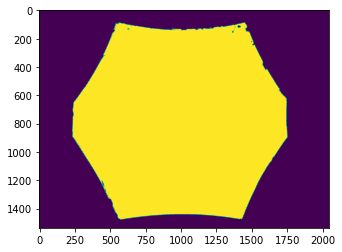

In [ ]:
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Depth Pred/mask/average_mask.jpg'
mask = cv2.imread(path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
thrshld = 50
mask = (mask>thrshld)*1
plt.imshow(mask*255)

mask = cv2.resize(mask.astype(np.float32),(256, 192),interpolation=cv2.INTER_NEAREST)
mask = mask.astype(bool)

mask_input = torch.tensor(mask).to(device)

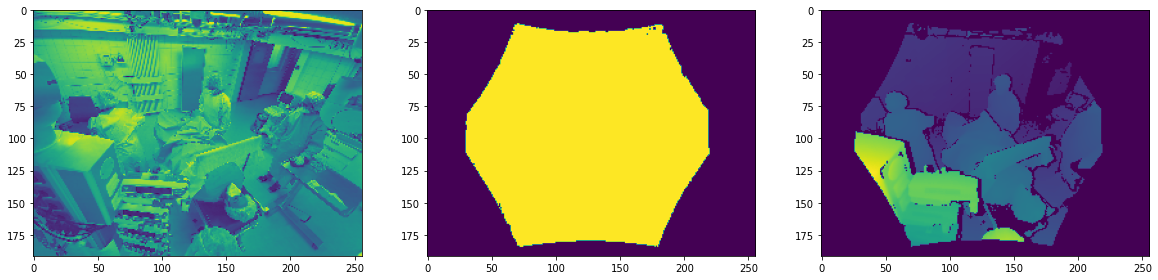

In [ ]:
batch = next(iter(My_Dataloader['train']))
img, inv_d = batch

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs[0].imshow(img[0,0])
axs[1].imshow(mask_input.cpu())
axs[2].imshow(inv_d[0])

## Train

In [ ]:
with open('/content/drive/MyDrive/Depth Pred/Save_Path/Save Train and Val loss List/train_result.pkl', 'rb') as f:
    train_result = pickle.load(f)

with open('/content/drive/MyDrive/Depth Pred/Save_Path/Save Train and Val loss List/val_result.pkl', 'rb') as f:
    val_result = pickle.load(f)

In [ ]:
num_epochs = 300
optimize = True
PATH = '/content/drive/MyDrive/Depth Pred/Save_Path/dpt_small_Trained.pt'

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10) 

    #for phase in ['train','val']:
    for phase in ['train','val']:  
        if phase == "train":
            model.train() # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0

        for batch in My_Dataloader[phase]:
            image_batch, inv_depth_batch = batch

            inv_depth_batch = inv_depth_batch.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                
                sample = image_batch.to(device)
                #if optimize==True and device == torch.device("cuda"):
                #    sample = sample.to(memory_format=torch.channels_last)  
                #    sample = sample.to(torch.float32)

                prediction = model.forward(sample)
                
                loss = loss_func(prediction, inv_depth_batch, mask_input)

            if phase == 'train':
                loss.backward()
                optimizer.step() 

            running_loss += loss.item() * batch_size
            del inv_depth_batch, sample, prediction, loss
            torch.cuda.empty_cache()

        epoch_loss = running_loss / len(My_Dataloader[phase].dataset)

        if phase == 'train':
            train_result.append(epoch_loss)
        elif phase == 'val':
            val_result.append(epoch_loss)

        print('Phase: {}, Loss: {:.4f}'.format(phase, epoch_loss))

    if epoch % 10 == 0: 
            torch.save(model.state_dict(), PATH)
            print("saved")

Epoch 0/299
----------
Phase: train, Loss: 0.2673
Phase: val, Loss: 0.2567
saved
Epoch 1/299
----------
Phase: train, Loss: 0.2494
Phase: val, Loss: 0.2458
Epoch 2/299
----------
Phase: train, Loss: 0.2371
Phase: val, Loss: 0.2397
Epoch 3/299
----------
Phase: train, Loss: 0.2296
Phase: val, Loss: 0.2346
Epoch 4/299
----------
Phase: train, Loss: 0.2236
Phase: val, Loss: 0.2322
Epoch 5/299
----------
Phase: train, Loss: 0.2193
Phase: val, Loss: 0.2299
Epoch 6/299
----------
Phase: train, Loss: 0.2159
Phase: val, Loss: 0.2280
Epoch 7/299
----------
Phase: train, Loss: 0.2123
Phase: val, Loss: 0.2253
Epoch 8/299
----------
Phase: train, Loss: 0.2095
Phase: val, Loss: 0.2234
Epoch 9/299
----------
Phase: train, Loss: 0.2070
Phase: val, Loss: 0.2224
Epoch 10/299
----------
Phase: train, Loss: 0.2049
Phase: val, Loss: 0.2213
Epoch 11/299
----------
Phase: train, Loss: 0.2030
Phase: val, Loss: 0.2196
Epoch 12/299
----------
Phase: train, Loss: 0.2012
Phase: val, Loss: 0.2186
Epoch 13/299
---

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'TiffImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)


TypeError: ignored

In [ ]:
import pickle

with open('/content/drive/MyDrive/Depth Pred/Save_Path/Save Train and Val loss List/train_result.pkl', 'wb') as f:
    pickle.dump(train_result, f)

with open('/content/drive/MyDrive/Depth Pred/Save_Path/Save Train and Val loss List/val_result.pkl', 'wb') as f:
    pickle.dump(val_result, f)

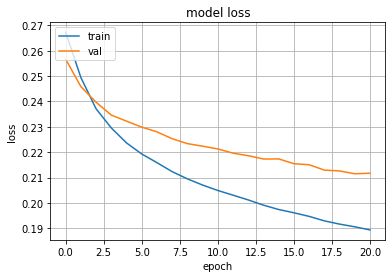

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_result)
plt.plot(val_result)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/Depth Pred/Save_Path/dpt_small_Trained.pt'

torch.save(model.state_dict(), PATH)